# Try Xarray

Derived from...
* http://xarray.pydata.org/en/stable/
* https://towardsdatascience.com/basic-data-structures-of-xarray-80bab8094efa
* https://towardsdatascience.com/handling-netcdf-files-using-xarray-for-absolute-beginners-111a8ab4463f


## Read the NetCDF Dataset as Xarray object

- Import requrired modules/packages
- Scan for NC files in /data folder
- Open a sample NC file & explore groups, dimensions, variables
- 

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

# define config constant (to be parms in code)
data_path = "../data/"
netCDF_extension = "nc"

In [3]:
data = xr.DataArray(np.random.randn(2, 3), dims=('x', 'y'), coords={'x': [10, 20]})
data

<xarray.DataArray (x: 2, y: 3)>
array([[ 0.35401445, -0.17115416, -1.08153872],
       [-1.53277077,  0.79719016,  0.11095484]])
Coordinates:
  * x        (x) int32 10 20
Dimensions without coordinates: y

In [7]:
ds = xr.open_dataset(data_path + 'tornado3d' + '.' + netCDF_extension)
ds

<xarray.Dataset>
Dimensions:  (xdim: 128, ydim: 128, zdim: 128)
Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
Data variables:
    u        (zdim, ydim, xdim) float32 ...
    v        (zdim, ydim, xdim) float32 ...
    w        (zdim, ydim, xdim) float32 ...
Attributes:
    creation_date:  16-Apr-2019 17:36:10
    grid:           regular

In [12]:
ds.coords

Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0

In [10]:
ds.dims

Frozen(SortedKeysDict({'zdim': 128, 'ydim': 128, 'xdim': 128}))

In [13]:
ds.attrs

{'creation_date': '16-Apr-2019 17:36:10', 'grid': 'regular'}

In [22]:
# try converting to pandas dataframe  
# NOTE: actually bound conversion method to object, rather than converting

df = ds.to_dataframe
df

<bound method Dataset.to_dataframe of <xarray.Dataset>
Dimensions:  (xdim: 128, ydim: 128, zdim: 128)
Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
Data variables:
    u        (zdim, ydim, xdim) float32 ...
    v        (zdim, ydim, xdim) float32 ...
    w        (zdim, ydim, xdim) float32 ...
Attributes:
    creation_date:  16-Apr-2019 17:36:10
    grid:           regular>

## Reshape CDF variables

Have 3 variables (u,v,w) each with shape = (128,128,128). Need one array of shape (128,128,128,3).

In [78]:
# start with simple example...

size = 7
u = np.random.randint(0,100,(size,size,size))
v = np.random.randint(0,100,(size,size,size))
w = np.random.randint(0,100,(size,size,size))
print('v shape = ', u.shape)

# combine with np.stack making the new dimension the last
uvw = np.stack((u, v, w), axis=-1)
print('uvw shape = ', uvw.shape)
print('total cells are ', np.prod(uvw.shape))   # uvw.shape

v shape =  (7, 7, 7)
uvw shape =  (7, 7, 7, 3)
total cells are  1029


In [54]:
# Are the cells of u & v & w the same as  uvw(1,1,1,:)

for i in range(size): print((u[i,i,i], v[i,i,i], w[i,i,i]), 'when stacked... ', uvw[i,i,i,:])

(77, 51, 67) when stacked...  [77 51 67]
(36, 26, 4) when stacked...  [36 26  4]
(35, 99, 87) when stacked...  [35 99 87]
(33, 68, 13) when stacked...  [33 68 13]
(8, 67, 89) when stacked...  [ 8 67 89]
(74, 45, 70) when stacked...  [74 45 70]
(83, 48, 36) when stacked...  [83 48 36]


## Set np.arrays for u,v,w from our sample netCDL dataset

In [79]:
u = np.array(ds.data_vars['u'])
v = np.array(ds.data_vars['v'])
w = np.array(ds.data_vars['w'])
u.shape

(128, 128, 128)

## Combine three variable into one using np.stack

In [80]:
# combine with np.stack making the new dimension the last

uvw = np.stack((u, v, w), axis=-1)
print('uvw shape = ', uvw.shape)
print('total cells are ', np.prod(uvw.shape))   # uvw.shape

uvw shape =  (128, 128, 128, 3)
total cells are  6291456


## Find min-max of u-v-w velocities

In [87]:
uvw_min = np.amin(uvw)
uvw_min

-6.2111263

In [88]:
uvw_max = np.amax(uvw)
uvw_max

6.2132716

## Normalize and scale 255 for RGB color

using x_norm = 256*(X-uvw_min)/(uvw_max-uvw_min)

In [89]:
uvw_norm = (255 * (uvw / (uvw_max-uvw_min) - (uvw_min/(uvw_max-uvw_min)))).astype(np.int)
uvw_norm[:2,:2,:2,:]

[[[[125  87 127]
   [126  87 127]]

  [[125  87 127]
   [126  87 127]]]


 [[[123  88 127]
   [124  87 127]]

  [[124  87 127]
   [125  87 127]]]]


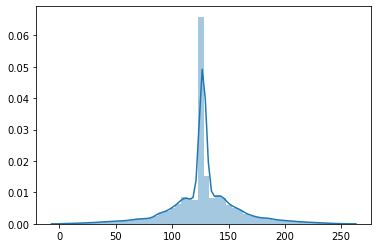

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Since >6M cells, random sample for efficiency
uvw_sample = np.random.choice(np.ndarray.flatten(uvw_norm), 100000)
sns.distplot(uvw_sample)

## Save UVW_norm to /Data 

In [111]:
np.save("../Data/tornado3d_norm.npy", uvw_norm)  #### interesting... NPY file is same size as orginal NC file

## Generate 3D image from UVW

In [108]:
# try pillow 
import pillow

ModuleNotFoundError: No module named 'pillow'

In [ ]:
################ References
# https://matplotlib.org/3.1.1/gallery/mplot3d/voxels.html  An easy introduction to 3D plotting with Matplotlib
# 

## Define function to list all files in directory with a specific extension (for later)

In [24]:


def list_files(directory, extension):
    return (f for f in listdir(directory) if f.endswith('.' + extension))

# List each nc file with its creation data and variables
for f in list_files(data_path, netCDF_extension):
    print(f)
    nc = Dataset(data_path + f, "r")
    nc_dict = nc.__dict__
    cdate = nc_dict['creation_date']
    vars = 
    print(f"{f} created {cdate} with variables {vars}")


tornado3d.nc
tornado3d.nc created 16-Apr-2019 17:36:10
